# VacationPy
---

## Starter Code to Import Libraries and Load the Weather and Coordinates Data

In [1]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import matplotlib.pyplot as plt


# Import API key
from api_keys import geoapify_key

In [11]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
city_data_df = pd.read_csv("output_data_file/cities.csv")

# Display sample data
city_data_df



,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,0,invercargill,-46.4000,168.3500,284.27,83,65,4.47,NZ,1714869500
1,1,hawaiian paradise park,19.5933,-154.9731,298.88,79,100,5.66,US,1714869501
2,2,adamstown,-25.0660,-130.1015,294.21,64,72,8.79,PN,1714869502
3,3,blackmans bay,-43.0167,147.3167,285.78,70,0,1.34,AU,1714869502
4,4,la libertad,-2.2333,-80.9000,297.69,79,65,3.45,EC,1714869503
...,...,...,...,...,...,...,...,...,...,...
571,571,papao,-17.7500,-149.5500,303.97,80,10,7.61,PF,1714869800
572,572,severnoye,56.3491,78.3619,279.81,94,96,3.58,RU,1714869801
573,573,sanctuary point,-35.1114,150.6290,288.01,87,100,2.26,AU,1714869801
574,574,souda,35.4844,24.0744,288.78,88,75,2.06,GR,1714869802


---

### Step 1: Create a map that displays a point for every city in the `city_data_df` DataFrame. The size of the point should be the humidity in each city.

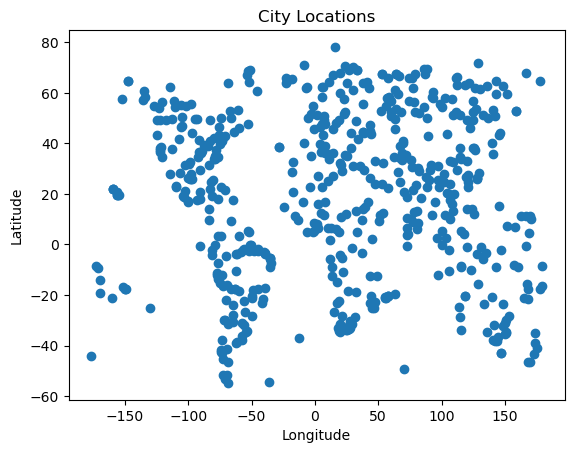

In [14]:
#map by plots

plt.scatter(city_data_df["Lng"], city_data_df["Lat"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("City Locations")
plt.show()

### Step 2: Narrow down the `city_data_df` DataFrame to find your ideal weather condition

In [18]:
# Narrow down cities that fit criteria and drop any results with null values
ideal_cond_df = city_data_df.loc[((city_data_df["Max Temp"] <= 1000.0) & (city_data_df["Max Temp"] >= 300.0))\
                                 & (city_data_df["Cloudiness"] == 20),:]

# Drop any rows with null values
ideal_cond_df = ideal_cond_df.dropna(how="any")

# Display sample data
ideal_cond_df.head()

,City_ID,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
19,19,georgetown,5.4112,100.3354,301.12,83,20,1.54,MY,1714869510
61,61,cabo san lucas,22.8909,-109.9124,301.82,41,20,2.06,MX,1714869532
96,96,alofi,-19.0595,-169.9187,303.09,79,20,3.60,NU,1714869551
127,127,itoman,26.1247,127.6694,300.16,75,20,7.72,JP,1714869568
240,240,bamboo flat,11.7000,92.7167,300.20,89,20,1.03,IN,1714869628


### Step 3: Create a new DataFrame called `hotel_df`.

In [19]:
%%capture --no-display
# capture added to remove false error when creating empty column

# Use the Pandas copy function to create DataFrame called hotel_df to store the city, country, coordinates, and humidity
hotel_df = ideal_cond_df[["City","Country","Lat","Lng","Humidity"]]

# Add an empty column, "Hotel Name," to the DataFrame so you can store the hotel found using the Geoapify API
hotel_df["Hotel Name"] = ""

# Display sample data
hotel_df.head()

,City,Country,Lat,Lng,Humidity,Hotel Name
19,georgetown,MY,5.4112,100.3354,83,
61,cabo san lucas,MX,22.8909,-109.9124,41,
96,alofi,NU,-19.0595,-169.9187,79,
127,itoman,JP,26.1247,127.6694,75,
240,bamboo flat,IN,11.7000,92.7167,89,


### Step 4: For each city, use the Geoapify API to find the first hotel located within 10,000 metres of your coordinates.

In [20]:
# Set parameters to search for a hotel
radius = 10000
params = {
    "apiKey":geoapify_key,
    "limit":10,
    "categories":"accommodation.hotel"
}

# Print a message to follow up the hotel search
print("Starting hotel search")

# Iterate through the hotel_df DataFrame
for index, row in hotel_df.iterrows():
    # get latitude, longitude from the DataFrame
    lat = row["Lat"]
    lon = row["Lng"]
    
    # Add filter and bias parameters with the current city's latitude and longitude to the params dictionary
    params["filter"] = f"circle:{lon},{lat},{radius}"
    params["bias"] = f"proximity:{lon},{lat}"
    
    # Set base URL
    base_url = "https://api.geoapify.com/v2/places"


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    
    # Grab the first hotel from the results and store the name in the hotel_df DataFrame
    try:
        hotel_df.loc[index, "Hotel Name"] = name_address["features"][0]["properties"]["name"]
    except (KeyError, IndexError):
        # If no hotel is found, set the hotel name as "No hotel found".
        hotel_df.loc[index, "Hotel Name"] = "No hotel found"
        
    # Log the search results
    print(f"{hotel_df.loc[index, 'City']} - nearest hotel: {hotel_df.loc[index, 'Hotel Name']}")

# Remove rows with "No hotel found"
hotel_df = hotel_df.loc[hotel_df["Hotel Name"] != "No hotel found",:]

# Display sample data
hotel_df

Starting hotel search
georgetown - nearest hotel: Page 63 hostel
cabo san lucas - nearest hotel: Comfort Rooms
alofi - nearest hotel: Matavai Resort
itoman - nearest hotel: No hotel found
bamboo flat - nearest hotel: Hotel Megapode Nest
pandan - nearest hotel: No hotel found
male - nearest hotel: Champa Central Hotel
kingston - nearest hotel: Aphrodite Hotel
kupang - nearest hotel: HOTEL SALUNGA
west bay - nearest hotel: Bonnie's Arch
labuan - nearest hotel: Labuan Avenue Hotel
punaauia - nearest hotel: Le Méridien


,City,Country,Lat,Lng,Humidity,Hotel Name
19,georgetown,MY,5.4112,100.3354,83,Page 63 hostel
61,cabo san lucas,MX,22.8909,-109.9124,41,Comfort Rooms
96,alofi,NU,-19.0595,-169.9187,79,Matavai Resort
240,bamboo flat,IN,11.7000,92.7167,89,Hotel Megapode Nest
309,male,MV,4.1748,73.5089,84,Champa Central Hotel
346,kingston,JM,17.9970,-76.7936,70,Aphrodite Hotel
396,kupang,ID,-10.1667,123.5833,79,HOTEL SALUNGA
533,west bay,KY,19.3667,-81.4167,78,Bonnie's Arch
535,labuan,MY,5.2767,115.2417,94,Labuan Avenue Hotel
552,punaauia,PF,-17.6333,-149.6000,70,Le Méridien


### Step 5: Add the hotel name and the country as additional information in the hover message for each city in the map.

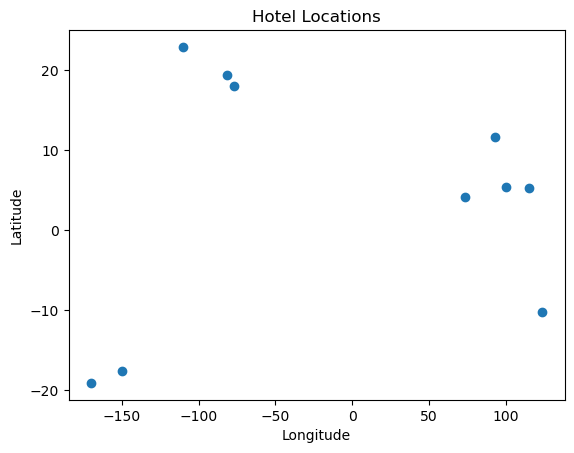

In [22]:
#%%capture --no-display

# Configure the map plot
#hotel_plot = hotel_df.hvplot.points(
#    "Lng",
#    "Lat",
#    geo=True,
#    tiles="OSM",
#    frame_width=650,
#    frame_height=500,
#    size="Humidity",
#    color="City",
#    hover_cols=["Hotel Name","Country"]
#    )

# Display the map
#hotel_plot

plt.scatter(hotel_df["Lng"], hotel_df["Lat"])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Hotel Locations")
plt.show()